In [1]:
import pandas as pd
import holoviews as hv
import numpy as np
import scanpy as sc
from holoviews import opts, dim

import scipy.cluster.hierarchy as hc
from scipy.spatial.distance import pdist
from sklearn.preprocessing import scale
from scipy.cluster.hierarchy import dendrogram
import fastcluster

import loompy
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgb
import os

from urllib.request import urlretrieve
from sknetwork.hierarchy import cut_straight
import scipy.cluster.hierarchy as hc
import numpy_groupies as npg
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import pdist, squareform
from scipy.stats import mode
from scipy import sparse
import seaborn
import matplotlib as mpl
import gget
import pickle
import networkx as nx
from umap import UMAP
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import NMF, PCA

# suppress INFO
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

# make font changeable in Illustrator
mpl.rcParams['pdf.fonttype'] = 42

# save figure with no pad
mpl.rcParams['savefig.pad_inches'] = 0
mpl.rcParams['savefig.bbox'] = 'tight'

# set axes width
mpl.rcParams['axes.linewidth'] = 0.2
mpl.rcParams['xtick.minor.pad'] = 0
mpl.rcParams['xtick.major.pad'] = 0
mpl.rcParams['ytick.minor.pad'] = 0
mpl.rcParams['ytick.major.pad'] = 0
mpl.rcParams['xtick.minor.width'] = 0.2
mpl.rcParams['xtick.major.width'] = 0.2
mpl.rcParams['ytick.minor.width'] = 0.2
mpl.rcParams['ytick.major.width'] = 0.2

# use colorblind seaborn style
plt.style.use('seaborn-colorblind')


/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/loompy/bus_file.py:68: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def twobit_to_dna(twobit: int, size: int) -> str:
/home/alejandro/miniconda3/envs/py39/lib/python3.9/site-packages/loompy/bus_file.py:85: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def dna_to_twobit(dna: str) -> int:
/home/alej

In [2]:
adata = sc.read_h5ad('../DataSubmission/GBM_Linnarsson_EEL.h5ad')
#adata_tumor_sc.X = adata_tumor_sc.layers['smooth']

In [11]:
classes = pd.Categorical(['differentiatingFB' if x.count('FB-like 1')  else x for x in adata.obs['m-states']])
classes = pd.Categorical(['RG-like' if x.count('nIPC-RG-like')  else x for x in classes])
#classes = adata.obs['CombinedNameMergeImmune']
PC3 = [x.split(' ')[0] for x in classes]
PC3 = pd.Categorical(['Endothelial' if x.count('Mural') else x for x in PC3])
PC3 = pd.Categorical(['Immune' if x.count('DC') or x.count('TAM-BDM') or x.count('Mono') or x.count('TAM-MG') else x for x in PC3])
adata.obs['PredictedClass3'] = pd.Categorical(PC3)

In [12]:
df_table = adata.obs.pivot_table(values='Area',index='Sample', columns='PredictedClass3', aggfunc=np.sum)
df_table = df_table.drop(columns=['Erythrocyte','unknown', 'unknown2', 'differentiatingFB'])



In [13]:
obs = adata.obs

In [14]:

palette_classes = {
    'GBL-like':'#c2f970',#'#c2f970'
    'AC-like':'#2ecc71',#inchworm B4FF9F
    'preOPC-like':'#7befb2',#'#c2f970'
    'GW-like': '#e76d89',
    'nIPC-like':'#FFF192',
    'RG-like':'#ff9470',
    'nIPC-RG-like':'#ff9470',
    'OPC-like':'#89c4f4',
    'FB-like': '#f1e7fe',#'#FF6EC7', #fff9de
    
    'Endothelial':'#8c14fc',
    'Immune':'#825e5c',
    'Oligodendrocyte':'#392e4a'

}


In [17]:
from sklearn.preprocessing import StandardScaler, RobustScaler, Normalizer
df_table = (df_table/df_table.sum(axis=1).values[:,None]) * 100
# Sample order from dendrogram in following figure (low and high wound response)
sample_order = [
    'SL061C', 'SL057B', 'SL040D', 'SL003', 'SL012', 'SL040F', 'SL001B', 'SL001A',
    'SL016A', 'SL057A', 'SL037', 'SL023', 'SL046C', 'SL046B', 'SL046A', 'SL035B', 'SL035A', 'SL006', 'SL002', 'SL027B',
    'SL053','SL019', 'SL015', 'SL034', 'SL038', 'SL029', 'SL061B', 'SL061A','SL040B', 'SL040E', 'SL018', 'SL020', 'SL030',
    'SL016B', 'SL040C', 'SL011', 'SL040Bulk', 'SL047B', 'SL013', 'SL005',
]


In [18]:
from tqdm import tqdm

# get Samples

#samples = np.unique(obs.Sample)
#unique_samples = samples
unique_samples = sample_order
x = [x for x in range(len(unique_samples))]
clusters = df_table.columns

ordering_sc_str = ['FB-like','GW-like','AC-like','GBL-like', 'preOPC-like','OPC-like','nIPC-like','RG-like','Endothelial', 'Immune', 'Oligodendrocyte'][::-1]


tumour = ['FB-like','GW-like','AC-like','GBL-like', 'preOPC-like','OPC-like','nIPC-like','RG-like']
nontumour = ['Endothelial','Immune', 'OL']

counts = []
x = []
tumor_bars = {
    'FB-like':[],'GW-like':[],'AC-like':[],'GBL-like':[], 'preOPC-like':[],'OPC-like':[],'nIPC-like':[],'RG-like':[], 
}
nontumor_bars = {
    'Endothelial':[],
    'Immune':[],
    'Oligodendrocyte':[]
}



bars = [tumor_bars, nontumor_bars]
y = []
colors = []

for i, s in tqdm(enumerate(unique_samples)):
    #print(s)
    r = df_table.loc[s,:]
    r = r[ordering_sc_str]
    r = r.to_dict()
    for b in bars:
        for ct in b:
            b[ct].append(r[ct])


40it [00:00, 753.12it/s]


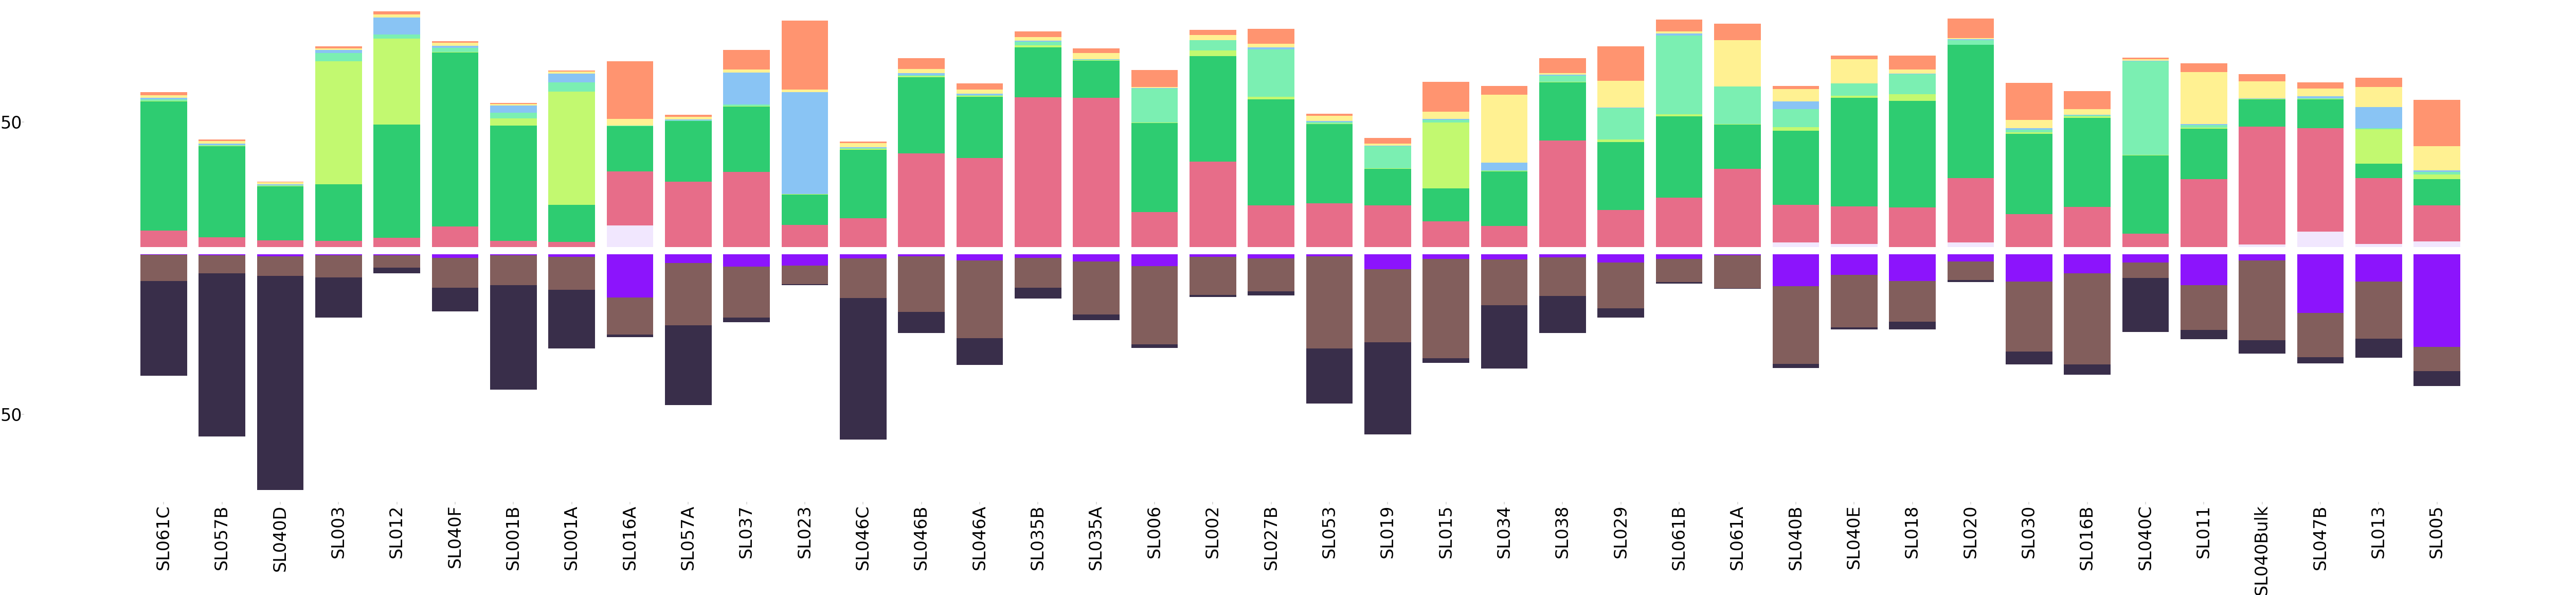

In [22]:
fig, axes = plt.subplots(figsize=(50, 10) , nrows = 2, ncols = 1,sharex=True, gridspec_kw={'height_ratios': [2, 2 ]})
fig.tight_layout(pad=0)
              
reorder_samples_by_GBMap = []

bottom = np.zeros_like(unique_samples)
tumor_bars = pd.DataFrame(tumor_bars, index=unique_samples)


sum_tumor = tumor_bars.sum(axis=1).values
nontumor_bars = pd.DataFrame(nontumor_bars, index=unique_samples)
sum_nontumor = nontumor_bars.sum(axis=1).values
df = tumor_bars/tumor_bars.values.sum(axis=1)[:,None]*100 *(sum_tumor/(sum_tumor+sum_nontumor))[:,None]
'''metric='euclidean'
method = 'ward'
D = pdist(df.values, metric)
Z = fastcluster.linkage(D, method=method,metric=metric, preserve_input=True)
Z = hc.optimal_leaf_ordering(Z, D, metric=metric)
ordering_samples = hc.leaves_list(Z)
ordering_samples_str = df.index[ordering_samples]'''

ordering_samples_str = sample_order
unique_samples = sample_order
tumor_bars = df.loc[ordering_samples_str]


### Non-tumor
bottom = np.zeros(len(unique_samples))
nontumor_bars = pd.DataFrame(nontumor_bars, index=unique_samples)
sum_nontumor = nontumor_bars.sum(axis=1).values
df = nontumor_bars/nontumor_bars.values.sum(axis=1)[:,None]*100 *(sum_nontumor/(sum_tumor+sum_nontumor))[:,None]
nontumor_bars = df.loc[ordering_samples_str]

unique_samples = ordering_samples_str
ax1 = axes[0]
#ax1.axis('off')
ax1.spines[['top','bottom','left', 'right']].set_visible(False)
ax1.set_yticks([0,50])
ax1.xaxis.set_visible(False) 
ax1.yaxis.set_visible(True) 

ax1.set_yticklabels([0,50],fontsize=24)

for ct in tumor_bars:
    ax1.bar(unique_samples,height=tumor_bars[ct],bottom=bottom, color=palette_classes[ct])
    bottom += tumor_bars[ct]
    

ax2 = axes[1]
ax2.spines[['top','bottom','left', 'right']].set_visible(False)
ax2.set_yticks([-50])
ax2.set_yticklabels(['50'] ,fontsize=24)
ax2.xaxis.set_visible(True) 
plt.yticks(fontsize=24)
#ax2.yaxis.set_visible(False) 
bottom = np.zeros(len(unique_samples))
for ct in nontumor_bars:
    ax2.bar(unique_samples,height=-nontumor_bars[ct],bottom=-bottom, color=palette_classes[ct])
    bottom += nontumor_bars[ct]
    
ax2.set_xticklabels(unique_samples,rotation=90, fontsize=24)
plt.show()

In [22]:
len(unique_samples)

40

In [23]:
len(sample_order)

40